# **Food Demand Forecasting**

Página de concurso: Analytics Vidhya [Food Demand Forecasting](https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/)

## 1. Entendimiento del Problema

### 1.1 Panorama General
El pronóstico de demanda es muy importante para el crecimiento de los negocios en línea. Sin los procesos de previsión de demanda correctos, puede ser casi imposible tener la cantidad adecuada de insumos en un momento dado.

Entrando en detalle, un servicio de entrega de alimentos tiene que lidiar con muchas cantidades de materias primas, lo cuál es un indicador muy importante para que las empresas tengan con la mayor precisión posible la demanda diaria y mensual. El hecho de tener demasiado inventario en el almacén significa un mayor riesgo de desperdicio de materia prima, por otro lado el poco inventario podría llevar a la falta de abastecimiento lo que podría resultar en un mayor problema el cual es hacer que los clientes busquen soluciones en nuestros competidores.

### 1.2. Planteamiento del Problema
El cliente que se tiene es una ***empresa de entrega de comida*** que opera en distintas ciudades. Dicha empresa tiene varios centros de cumplimiento en dichas ciudades para enviar comida a sus clientes. Se quiere tener un ***pronóstico de la demanda de dichos centros*** para las próximas semanas, de tal manera que puedan ***planificar el stock de materias primas***.

Tener en cuenta que, la reposición de las materias primas se realiza semanalmente y, debido a que la materia prima es perecedera, la planificación de las adquisiciones es de suma importancia. También, la asignación de personal de cada centro es un importante para que el pronóstico sea realmente útil.

**Objetivo:** Predecir la demanda para las próximas 10 semanas para la combinación de los alimentos de los centros en el conjunto de entrenamiento.

##2. Análisis y Visualización de datos

### 2.1 Importamos Librerías

In [66]:
# Importamos las librerias 
%matplotlib inline
!pip install catboost
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xg
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

sns.set(style="white")

In [67]:
!mkdir data
!wget "https://drive.google.com/uc?export=download&id=1EG9_l6a5rRlTSzEwlNijqLuY7bxW_iuP" -O data/fulfilment_center_info.csv
!wget "https://drive.google.com/uc?export=download&id=19v-eC9LKjbAH0DMqQpi8Sb0XVxnNm9uq" -O data/meal_info.csv
!wget "https://drive.google.com/uc?export=download&id=1-zCbExblslglkus85ZCTNWwDh3TiEgkl" -O data/test.csv
!wget "https://drive.google.com/uc?export=download&id=1DZj2egxfzXYltmL_1M_atDHXMwz6IsR_" -O data/train.csv

mkdir: cannot create directory ‘data’: File exists
--2020-05-01 22:21:05--  https://drive.google.com/uc?export=download&id=1EG9_l6a5rRlTSzEwlNijqLuY7bxW_iuP
Resolving drive.google.com (drive.google.com)... 74.125.141.100, 74.125.141.113, 74.125.141.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qhquisoqeoogr9lcjna9s9jcaitq7s8b/1588371600000/01100318546325464434/*/1EG9_l6a5rRlTSzEwlNijqLuY7bxW_iuP?e=download [following]
--2020-05-01 22:21:05--  https://doc-0c-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qhquisoqeoogr9lcjna9s9jcaitq7s8b/1588371600000/01100318546325464434/*/1EG9_l6a5rRlTSzEwlNijqLuY7bxW_iuP?e=download
Resolving doc-0c-00-docs.googleusercontent.com (doc-0c-00-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connec

### 2.2. Información del Cojunto de Entrenamiento

In [0]:
# Cargamos los datos 
fulfilment_center_info = pd.read_csv('data/fulfilment_center_info.csv')
meal_info = pd.read_csv('data/meal_info.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [69]:
# Mostramos los primeros datos de entrenamiento
print("Total de registros Train set: ", train.shape)
train.head()

Total de registros Train set:  (456548, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


Información estadística del Conjunto de Entrenamiento

In [70]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,456548.0,1.250096e+06,144354.822378,1000000.00,1124998.75,1250183.50,1375140.25,1499999.00
week,456548.0,7.476877e+01,41.524956,1.00,39.00,76.00,111.00,145.00
center_id,456548.0,8.210580e+01,45.975046,10.00,43.00,76.00,110.00,186.00
meal_id,456548.0,2.024337e+03,547.420920,1062.00,1558.00,1993.00,2539.00,2956.00
checkout_price,456548.0,3.322389e+02,152.939723,2.97,228.95,296.82,445.23,866.27
base_price,456548.0,3.541566e+02,160.715914,55.35,243.50,310.46,458.87,866.27
emailer_for_promotion,456548.0,8.115247e-02,0.273069,0.00,0.00,0.00,0.00,1.00
homepage_featured,456548.0,1.091999e-01,0.311890,0.00,0.00,0.00,0.00,1.00
num_orders,456548.0,2.618728e+02,395.922798,13.00,54.00,136.00,324.00,24299.00


### 2.3. Información del Conjunto de Pruebas

In [71]:
# Mostramos los primeros datos de pruebas
print("Total de registros Test set: ", test.shape)
test.head()

Total de registros Test set:  (32573, 8)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


Información estadística de Conjunto de Pruebas

In [72]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,32573.0,1.248476e+06,144158.048324,1000085.00,1123969.00,1247296.00,1372971.00,1499996.00
week,32573.0,1.504778e+02,2.864072,146.00,148.00,150.00,153.00,155.00
center_id,32573.0,8.190173e+01,45.950455,10.00,43.00,76.00,110.00,186.00
meal_id,32573.0,2.032068e+03,547.199004,1062.00,1558.00,1993.00,2569.00,2956.00
checkout_price,32573.0,3.418544e+02,153.893886,67.90,214.43,320.13,446.23,1113.62
base_price,32573.0,3.564936e+02,155.150101,89.24,243.50,321.13,455.93,1112.62
emailer_for_promotion,32573.0,6.643539e-02,0.249045,0.00,0.00,0.00,0.00,1.00
homepage_featured,32573.0,8.135572e-02,0.273385,0.00,0.00,0.00,0.00,1.00


### 2.4. Información de los Centros y Comidas

In [73]:
# Mostramos primeros datos de los centros
print("Total de registros de centros:", fulfilment_center_info.shape)
fulfilment_center_info.head()

Total de registros de centros: (77, 5)


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [74]:
# Valores únicos de centros
center_types = pd.DataFrame({'center_type': fulfilment_center_info['center_type'].unique() }).reset_index()
center_types

,index,center_type
0,0,TYPE_A
1,1,TYPE_B
2,2,TYPE_C


In [75]:
# Mostramos primeros datos de las comidas
print("Total de registros de comidas:", meal_info.shape)
meal_info.head()

Total de registros de comidas: (51, 3)


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [76]:
cuisine_category = meal_info.groupby(['cuisine', 'category']).count()
cuisine_category.rename(columns={'meal_id': 'total'})

total
cuisine     category           
Continental Beverages         3
            Fish              3
            Pizza             3
            Seafood           3
Indian      Beverages         3
            Biryani           3
            Desert            3
            Rice Bowl         3
Italian     Beverages         3
            Pasta             3
            Salad             3
            Sandwich          3
Thai        Beverages         3
            Extras            3
            Other Snacks      3
            Soup              3
            Starters          3

### 2.5. Verificación de datos faltantes

In [77]:
# Verificamos si hay valores nulos en el conjunto de entrenamiento
train.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [78]:
# Verificamos si hay valores nulos en centros
fulfilment_center_info.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [79]:
# Verificamos si hay valores nulos en comidas
meal_info.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

### 2.6. Combinamos la data de entrenamiento, centros y comidas

In [0]:
# Juntamos los datos de train y test
train = pd.merge(train, fulfilment_center_info, how='left', left_on='center_id', right_on='center_id')
train = pd.merge(train, meal_info, how='left', left_on='meal_id', right_on='meal_id')

test = pd.merge(test, fulfilment_center_info, how='left', left_on='center_id', right_on='center_id')
test = pd.merge(test, meal_info, how='left', left_on='meal_id', right_on='meal_id')

###2.7. Análisis de variables y Visualizaciones

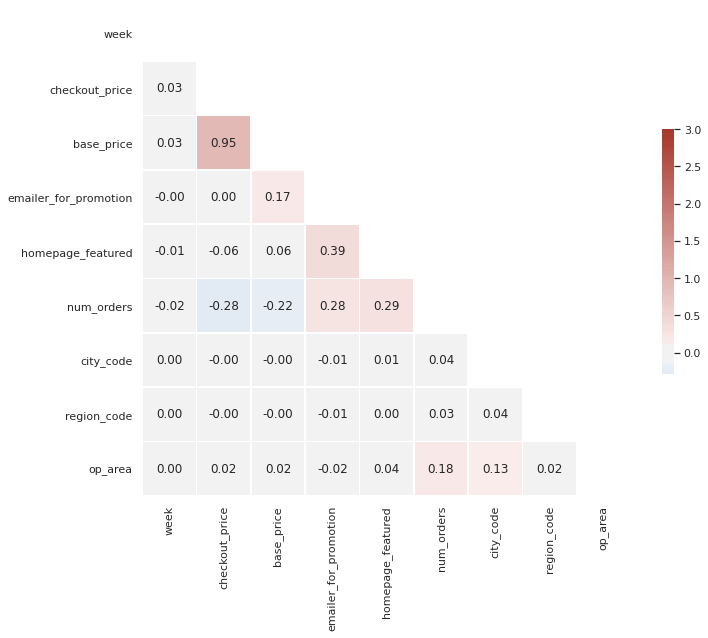

In [81]:
correlation = train.drop(['id', 'center_id', 'meal_id'], axis=1).corr(method='pearson')
mask = np.ones_like(correlation, dtype=np.bool)
mask = np.triu(mask)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=3., annot=True, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Text(0, 0.5, 'Cantidad de pedidos')

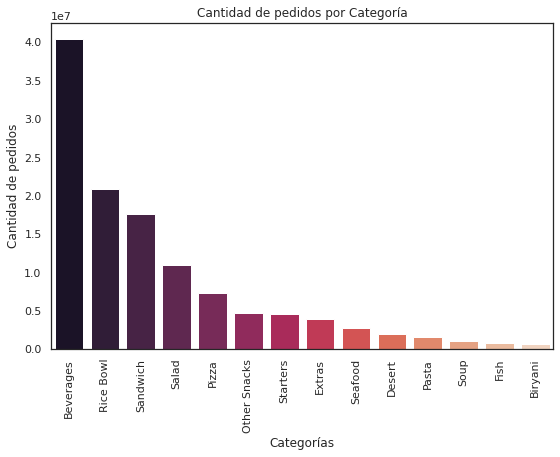

In [82]:
# Visualización de Categorías vs Cantidad de Pedidos
plt.figure(figsize=(9, 6))
group_categories=train.groupby('category')['num_orders'].sum().sort_values(ascending=False).reset_index()
sns.barplot(x='category', y='num_orders', data=group_categories, palette='rocket')
plt.xticks(rotation = 90)
plt.title("Cantidad de pedidos por Categoría")
plt.xlabel("Categorías")
plt.ylabel("Cantidad de pedidos")

Podemos visualizar que las tres categorías más solicitadas son ***Beverages*** , ***Rice Bowl*** y ***Sandwich***

Text(0, 0.5, 'Cantidad de pedidos')

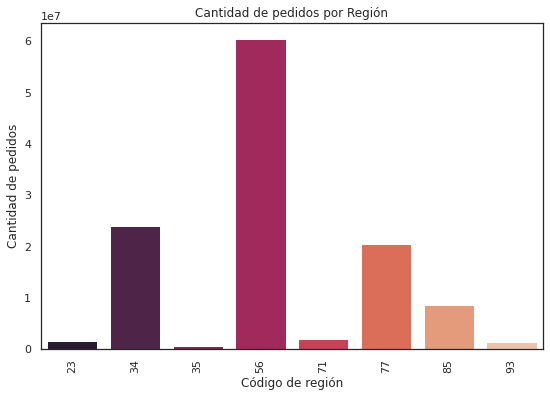

In [83]:
# Visualización de Región vs Cantidad de Pedidos
plt.figure(figsize=(9, 6))
group_categories=train.groupby('region_code')['num_orders'].sum().sort_values(ascending=False).reset_index()
sns.barplot(x='region_code', y='num_orders', data=group_categories, palette='rocket')
plt.xticks(rotation = 90)
plt.title("Cantidad de pedidos por Región")
plt.xlabel("Código de región")
plt.ylabel("Cantidad de pedidos")

La región que **56** es la que tiene mayor pedidos

Text(0, 0.5, 'Cantidad de pedidos')

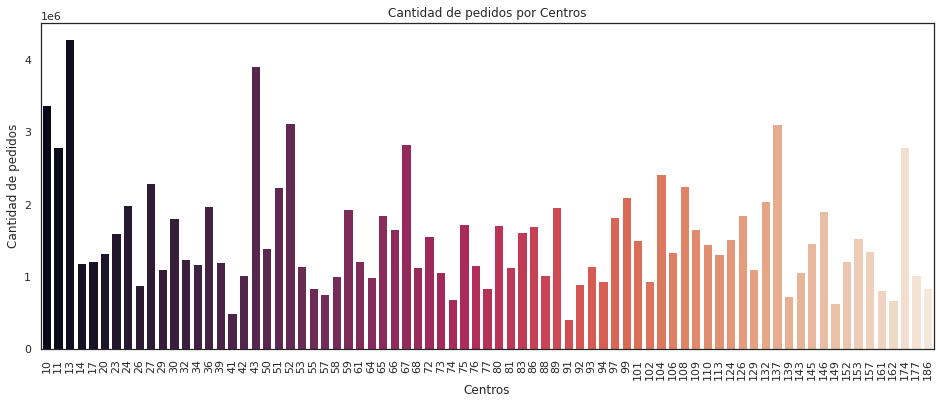

In [84]:
# Visualización de Categorías vs Cantidad de Pedidos
plt.figure(figsize=(16, 6))
group_categories=train.groupby('center_id')['num_orders'].sum().sort_values(ascending=False).reset_index()
sns.barplot(x='center_id', y='num_orders', data=group_categories, palette='rocket')
plt.xticks(rotation = 90)
plt.title("Cantidad de pedidos por Centros")
plt.xlabel("Centros")
plt.ylabel("Cantidad de pedidos")

La distribución de pedidos en los centros no tiene un patrón que se pueda identificar claramente.

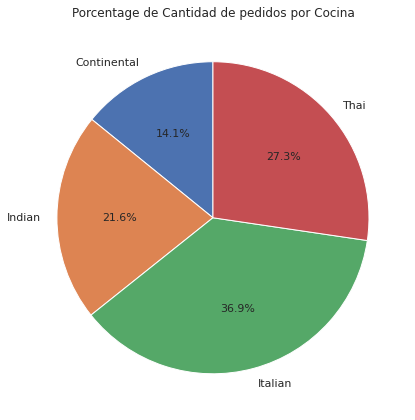

In [85]:
# Visualización de Cocinas vs Cantidad de Pedidos
plt.figure(figsize=(6, 6))
cuisine_group = train.groupby(['cuisine'])
plt.title("Porcentage de Cantidad de pedidos por Cocina")
plt.pie(cuisine_group['num_orders'].sum(),
        labels=cuisine_group['num_orders'].sum().index,
        shadow=False,
        autopct='%1.1f%%',
        pctdistance=0.6,
        startangle=90,
        textprops={'fontsize': 11})
plt.tight_layout()

Podemos visualizar el tipo de comida que prefieren los consumidores es la ***Italiana*** y la menos preferida es ***Continental***

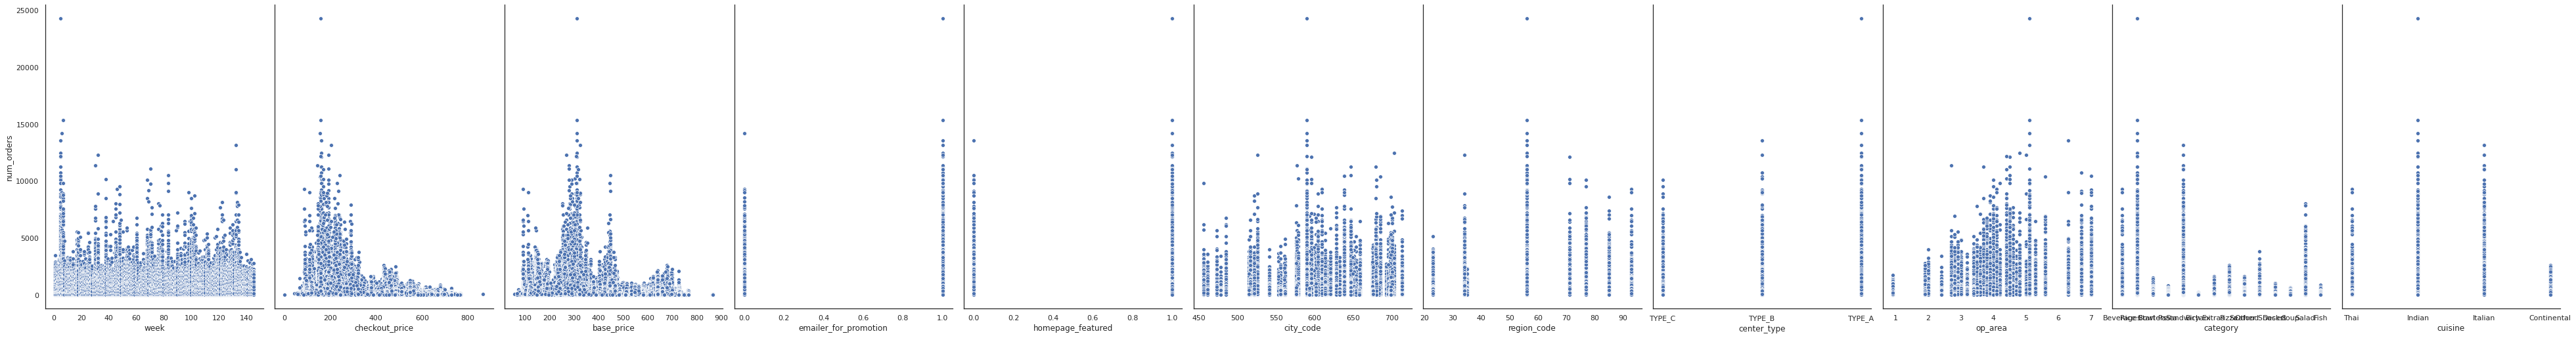

In [86]:
# Visualizamos las variables vs target
p = sns.pairplot(train, x_vars=['week','checkout_price','base_price','emailer_for_promotion','homepage_featured','city_code','region_code','center_type','op_area','category','cuisine'], y_vars='num_orders', height=7, aspect=0.7)

Aunque no es tan notorio, se puede visualizar **outliers** en los gráficos, más adelante veremos uno de los gráficos a detalle

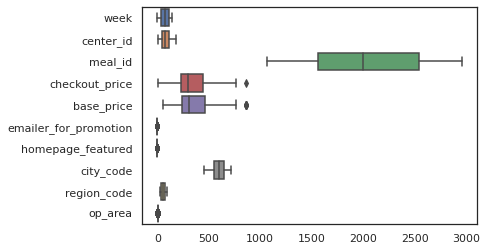

In [87]:
# Visualizamos el boxplot de las variables.
sns.boxplot(data=train.drop(columns=["id","num_orders"]), orient="h")

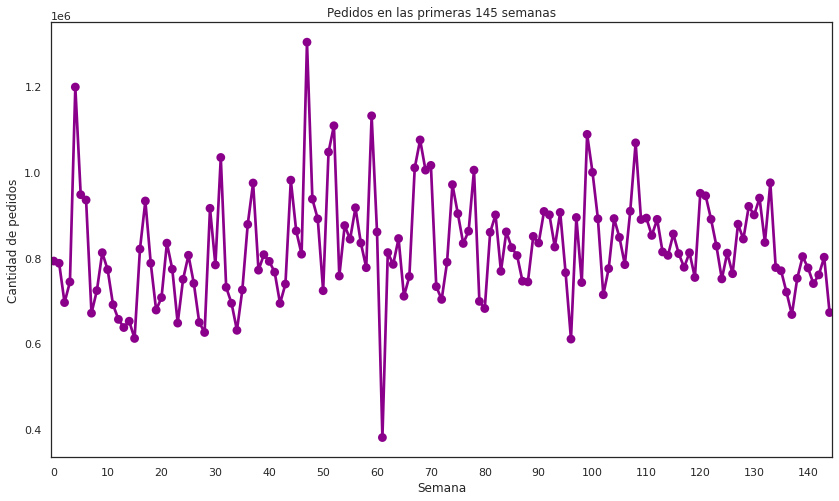

In [88]:
# Visualizamos el patrónpatrón de Cantidad de Pedidos durante las primeras 145 semanas
plt.figure(figsize=(14, 8))
group_week = train.groupby('week').sum().reset_index()
sns.pointplot(x=group_week['week'], y=group_week['num_orders'], color='darkmagenta')
plt.title("Pedidos en las primeras 145 semanas")
plt.xticks(range(0, 150, 10), range(0, 160, 10))
plt.xlabel("Semana")
plt.ylabel("Cantidad de pedidos")
plt.show()

Se puede visualizar que la menor cantidad de pedidos se hizo en la ***semana 60*** y la mayor cantidad de pedidos entre la ***semana 40 y 50***

###2.8. Eliminación de outliers

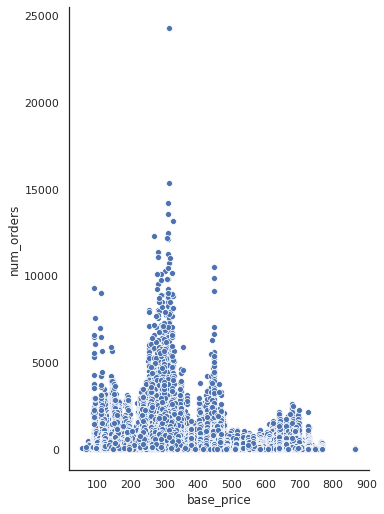

In [89]:
# Visualizamos las la cantidad de pedidos por semana
sns.pairplot(train, x_vars=['base_price'], y_vars='num_orders', height=7, aspect=0.7)
plt.show()

Como se puede visualizar en el gráfico, hay un valor que puede considerarse outlier, por lo cual tomaremos todos los valores menores a **1500** para eliminar dichos outliers

In [0]:
# Eliminamos dicho outlier
train = train[(train['num_orders'] < 15000)]

##3. Realizamos Feature Enginnering
Para esto nos hemos basamos del siguiente notebook: [Food Demand Forecasting](https://github.com/yashkim77/AV_Food_Demand_Challenge) , hicimos algunas modificaciones en la generación de columnas

###3.1. Escalamiento de datos y generación de nuevos features

In [91]:
# Aplicando escalamiento logarítmico a variables de precios y target
train['checkout_price'] = np.log1p(train['checkout_price'])
train['base_price'] = np.log1p(train['base_price'])
train['num_orders'] = np.log1p(train['num_orders'])

test['checkout_price'] = np.log1p(test['checkout_price'])
test['base_price'] = np.log1p(test['base_price'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [92]:
# Generamos la columna descuento en base al precio base y el precio de venta
train['discount'] = (train['base_price'] - train['checkout_price']) / train['base_price']
test['discount'] = (test['base_price'] - test['checkout_price']) / test['base_price']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
# Ordenamos los datos por centro, comida y semana
train = train.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)
test = test.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [0]:
# Generamos la columna de diferencia de precios
train['diff_price_week'] = train['checkout_price'] - train['checkout_price'].shift(1)
test['diff_price_week'] = test['checkout_price'] - test['checkout_price'].shift(1)
train['diff_price_week'] = train['diff_price_week'].fillna(0)
test['diff_price_week'] = test['diff_price_week'].fillna(0)

In [0]:
# Generamos la columna de promedio de número de ordenes por centro y comida
train_center_meal_orders_group = train.groupby(['center_id', 'meal_id'])['num_orders'].mean().reset_index()
train_center_meal_orders_group = train_center_meal_orders_group.rename(columns={'num_orders': 'mean_orders'})
train = pd.merge(train, train_center_meal_orders_group, how='left', left_on=['center_id', 'meal_id'], right_on=['center_id', 'meal_id'])
test = pd.merge(test, train_center_meal_orders_group, how='left', left_on=['center_id', 'meal_id'], right_on=['center_id', 'meal_id'])
test['mean_orders'] = test['mean_orders'].fillna(0)

In [0]:
# Creamos data con variables categoricas para CatBoostRegression
train_categorical = train.copy()
test_categorical = test.copy()
train_categorical['center_id'] = train_categorical['center_id'].astype(np.object)
test_categorical['center_id'] = test_categorical['center_id'].astype(np.object)
train_categorical['meal_id'] = train_categorical['meal_id'].astype(np.object)
test_categorical['meal_id'] = test_categorical['meal_id'].astype(np.object)
train_categorical['city_code'] = train_categorical['city_code'].astype(np.object)
test_categorical['city_code'] = test_categorical['city_code'].astype(np.object)
train_categorical['region_code'] = train_categorical['region_code'].astype(np.object)
test_categorical['region_code'] = test_categorical['region_code'].astype(np.object)

X_train_categorical = train_categorical.drop(['id', 'num_orders'], axis = 1)
X_test_categorical = test_categorical.drop(['id'], axis = 1)

In [0]:
# Creamos dummies
train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test)

In [0]:
X_train = train.drop(['id', 'center_id', 'meal_id', 'num_orders'], axis=1)
X_train_dummies = train_dummies.drop(['id', 'center_id', 'meal_id', 'num_orders'], axis=1)
Y_train = train['num_orders']

# Predicción
ids = test['id']
X_test = test.drop(['id','center_id', 'meal_id'], axis=1)
X_test_dummies = test_dummies.drop(['id','center_id', 'meal_id'], axis=1)

### 3.2. Visualización de correlación con nuevos datos

[]

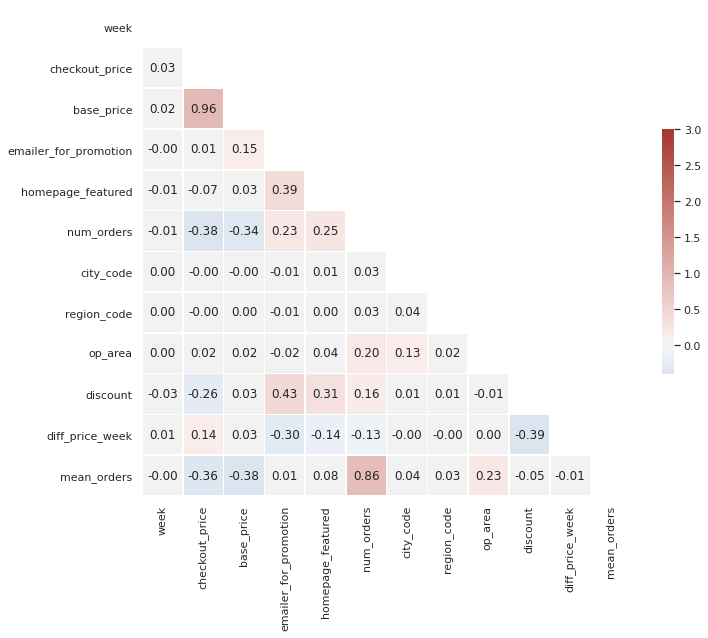

In [99]:
correlation = train.drop(['id', 'center_id', 'meal_id'], axis=1).corr()
mask = np.ones_like(correlation, dtype=np.bool)
mask = np.triu(mask)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=3., annot=True, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.plot()

In [0]:
#Fuente: https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
def plot_learning_curve(model, X, Y, cv=5):
  # Create CV training and test scores for various training set sizes
  train_sizes, train_scores, test_scores = learning_curve(model,X, Y,cv=cv)

  # Create means and standard deviations of training set scores
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)

  # Create means and standard deviations of test set scores
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  # Draw lines
  plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
  plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

  # Draw bands
  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

  # Create plot
  plt.title("Learning Curve")
  plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
  plt.tight_layout()
  plt.show()

## 4. Modelos y Métricas

Aplicamos algunos modelos y la métrica que se usa para evaluar los modelos son **Mean Square Error** y **Mean Square Logarithmic Error**

### 4.1 Árbol de Decisiones

#### Prueba 1: Aplicamos árbol de decisión con KFolds

Score Promedio
Train      = 0.8365
Validation = 0.8213
RMSLE Promedio
Train      = 48.65
Validation = 50.86
Base Line Compare = 110.1


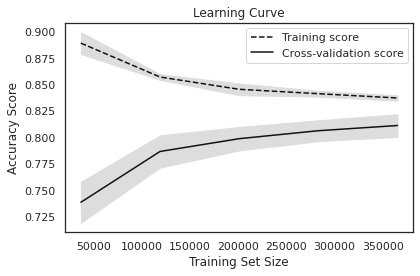

In [101]:
kfolds = KFold(n_splits=5, shuffle=True)

y = Y_train
x = X_train_dummies

base_score, train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], [], []

model = DecisionTreeRegressor(max_depth = 12)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmsle.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(model.predict(x_train)))))
    val_rmsle.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(model.predict(x_val)))))
    y_val[:]=y.mean()
    base_score.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(model.predict(x_val)))))

print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')
print(f'Base Line Compare = {np.mean(base_score):.4}')

plot_learning_curve(model, x, y)

#### Prueba 2: Aplicamos árbol de decisión con train/test split

Score Promedio
Train      = 0.837
Validation = 0.8203
RMSLE Promedio
Train      = 48.58
Validation = 51.0


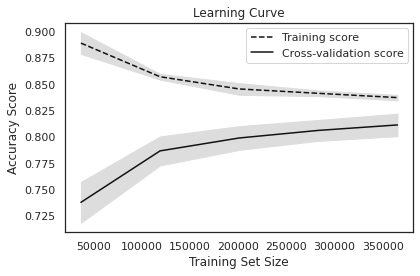

In [102]:
x_train, x_test, y_train, y_test = train_test_split(X_train_dummies, Y_train, test_size=0.30)

model = DecisionTreeRegressor(max_depth = 12)
model.fit(x_train, y_train)

print(f'Score Promedio')
print(f'Train      = {model.score(x_train, y_train):.4}')
print(f'Validation = {model.score(x_test, y_test):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {(100*np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(model.predict(x_train))))):.4}')
print(f'Validation = {(100*np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(model.predict(x_test))))):.4}')

plot_learning_curve(model, X_train_dummies, Y_train)

#### Prueba 3: Aplicamos árbol de decisión con profundidad 14

Score Promedio
Train      = 0.8511
Validation = 0.8225
RMSE Promedio
Train      = 46.43
Validation = 50.69


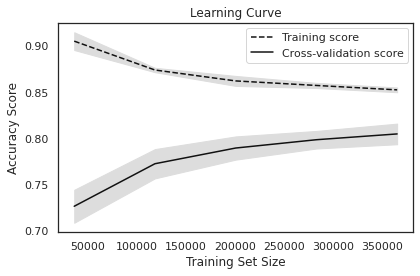

In [103]:
kfolds = KFold(n_splits=5, shuffle=True)

y = Y_train
x = X_train_dummies

train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], []
model = DecisionTreeRegressor(max_depth = 14, min_samples_leaf=3)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmsle.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(model.predict(x_train)))))
    val_rmsle.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_val),np.expm1(model.predict(x_val)))))
    
print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')

plot_learning_curve(model, X_train_dummies, Y_train)

### 4.2 Random Forest - Regresión

#### Prueba 1: Aplicamos RandomForest con KFolds

In [104]:
# Información revisada https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
kfolds = KFold(n_splits=5, shuffle=True)

y = Y_train
x = X_train_dummies

base_score, train_scores, val_scores, train_rmse, val_rmse = [], [], [], [], []

model = RandomForestRegressor(n_estimators = 160, max_depth=12,min_samples_leaf=3)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmse.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(model.predict(x_train)))))
    val_rmse.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_val),np.expm1(model.predict(x_val)))))
    y_val[:]=y.mean()
    base_score.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_val),np.expm1(model.predict(x_val)))))


print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSE Promedio')
print(f'Train      = {np.mean(train_rmse):.4}')
print(f'Validation = {np.mean(val_rmse):.4}')
print(f'Base Line Compare = {np.mean(base_score):.4}')

Score Promedio
Train      = 0.8444
Validation = 0.8329
RMSE Promedio
Train      = 47.46
Validation = 49.18
Base Line Compare = 109.2


#### Prueba 2. Aplicamos RandomForest con train/test split

In [105]:
y = Y_train
x = X_train_dummies

base_score, train_scores, val_scores, train_rmse, val_rmse = [], [], [], [], []
model = RandomForestRegressor(n_estimators = 200, max_depth=12, min_samples_leaf=3)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmse.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(model.predict(x_train)))))
    val_rmse.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(model.predict(x_val)))))
    y_val[:]=y.mean()
    base_score.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_val),np.expm1(model.predict(x_val)))))


print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSE Promedio')
print(f'Train      = {np.mean(train_rmse):.4}')
print(f'Validation = {np.mean(val_rmse):.4}')
print(f'Base Line Compare = {np.mean(base_score):.4}')

Score Promedio
Train      = 0.8444
Validation = 0.8329
RMSE Promedio
Train      = 47.46
Validation = 49.17
Base Line Compare = 109.2


### 4.3 Gradient Boosting Regression

#### Prueba 1: GradientBoosting cambio de hiperparámetros

In [106]:
kfolds = KFold(n_splits=4, shuffle=True)

y = Y_train
x = X_train_dummies

base_score, train_scores, val_scores, train_rmse, val_rmse = [], [], [], [], []

model = GradientBoostingRegressor(loss='ls',
                                n_estimators=180, max_depth=12,
                                learning_rate=0.1, min_samples_leaf=5,
                                min_samples_split=8)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmse.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(model.predict(x_train)))))
    val_rmse.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(model.predict(x_val)))))
    y_val[:]=y.mean()
    base_score.append(100*np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(model.predict(x_val)))))
    
print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSE Promedio')
print(f'Train      = {np.mean(train_rmse):.4}')
print(f'Validation = {np.mean(val_rmse):.4}')
print(f'Base Line Compare = {np.mean(base_score):.4}')

Score Promedio
Train      = 0.9141
Validation = 0.8634
RMSE Promedio
Train      = 35.26
Validation = 44.47
Base Line Compare = 111.6


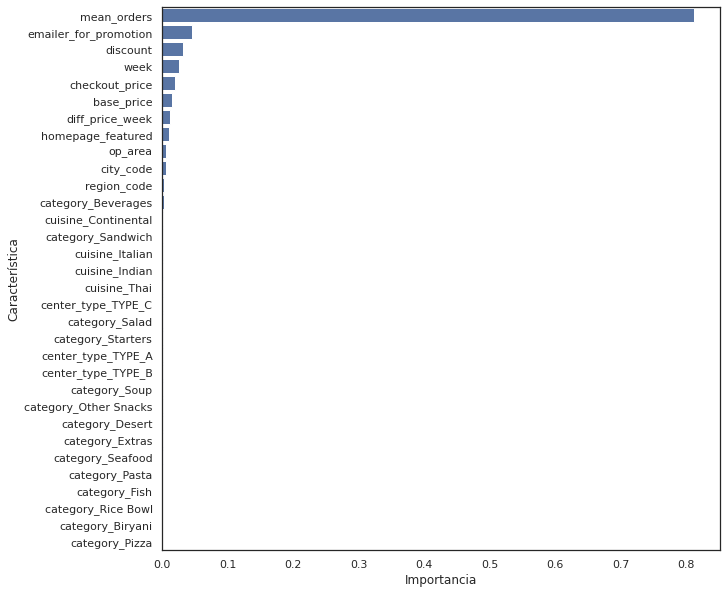

In [107]:
importances = pd.DataFrame({ 'importance': model.feature_importances_ })
importances['feature'] = x.columns
importances_sorted = importances.sort_values(by='importance', ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
fig =sns.barplot(x='importance',
                 y='feature', 
                 data=importances_sorted, 
                 label="Importancia de Características", 
                 color="b")

plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show(fig)

In [0]:
# Predicción
y_pred = model.predict(X_test_dummies)
predictions = pd.DataFrame({'id': ids, 
                           'num_orders': np.expm1(y_pred)})
predictions.to_csv('submission_gradient_boosting.csv', index=False)

### 4.4 Cat Boosting Regression

#### Prueba 1: CatBoostRegressor con profundidad 12 y dummies

In [109]:
# Lista de parámetros https://catboost.ai/docs/concepts/python-reference_parameters-list.html?lang=en
x = X_train_dummies
y = Y_train
train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], []

catboost_model = CatBoostRegressor(iterations=2400,
                                   learning_rate=0.01,
                                   max_depth=12,
                                   l2_leaf_reg=10, 
                                   od_type='Iter',
                                   loss_function='RMSE',
                                   use_best_model=True)

kfolds = KFold(n_splits=4, shuffle=True)

for train_idx, val_idx in kfolds.split(x):
  x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
  x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
  catboost_model.fit(x_train, y_train, eval_set=(x_val, y_val), verbose=200)
  train_scores.append(catboost_model.score(x_train, y_train))
  val_scores.append(catboost_model.score(x_val, y_val))
  train_rmsle.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(catboost_model.predict(x_train)))))
  val_rmsle.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(catboost_model.predict(x_val)))))

print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')

0:	learn: 1.1943543	test: 1.1920143	best: 1.1920143 (0)	total: 267ms	remaining: 10m 40s
200:	learn: 0.5378606	test: 0.5397668	best: 0.5397668 (200)	total: 24.9s	remaining: 4m 32s
400:	learn: 0.4983393	test: 0.5012771	best: 0.5012771 (400)	total: 49.5s	remaining: 4m 6s
600:	learn: 0.4869310	test: 0.4905520	best: 0.4905520 (600)	total: 1m 14s	remaining: 3m 42s
800:	learn: 0.4793589	test: 0.4836528	best: 0.4836528 (800)	total: 1m 38s	remaining: 3m 17s
1000:	learn: 0.4737434	test: 0.4787792	best: 0.4787792 (1000)	total: 2m 3s	remaining: 2m 52s
1200:	learn: 0.4690704	test: 0.4748360	best: 0.4748360 (1200)	total: 2m 27s	remaining: 2m 27s
1400:	learn: 0.4651949	test: 0.4716424	best: 0.4716424 (1400)	total: 2m 52s	remaining: 2m 2s
1600:	learn: 0.4616334	test: 0.4687818	best: 0.4687818 (1600)	total: 3m 16s	remaining: 1m 38s
1800:	learn: 0.4584298	test: 0.4663088	best: 0.4663088 (1800)	total: 3m 41s	remaining: 1m 13s
2000:	learn: 0.4555406	test: 0.4642006	best: 0.4642006 (2000)	total: 4m 5s	rema

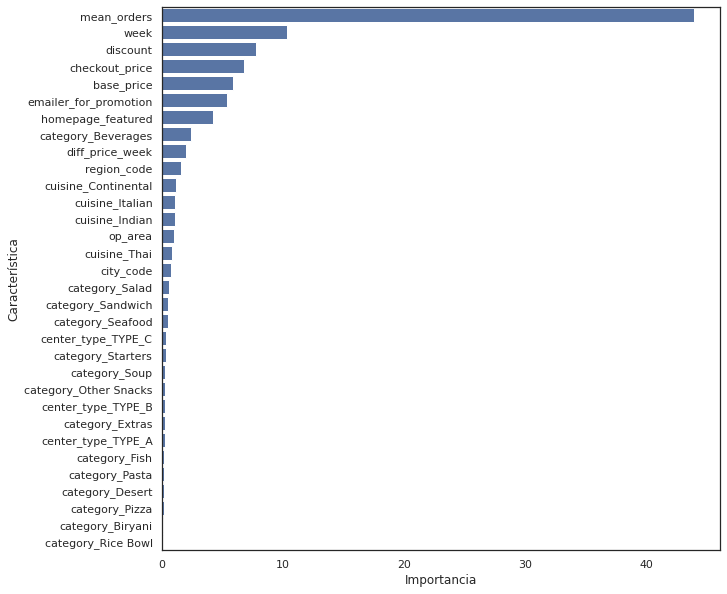

In [110]:
importances = pd.DataFrame({ 'importance': catboost_model.feature_importances_ })
importances['feature'] = x.columns
importances_sorted = importances.sort_values(by='importance', ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
fig =sns.barplot(x='importance',
                 y='feature', 
                 data=importances_sorted, 
                 label="Importancia de Características", 
                 color="b")

plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show(fig)

In [0]:
# Predicción
y_pred = catboost_model.predict(X_test_dummies)
predictions = pd.DataFrame({'id': ids, 
                           'num_orders': np.expm1(y_pred)})
predictions.to_csv('catboost_submission_model_1.csv', index=False)

#### Prueba 2: CatBoostRegressor con profundidad 8 sin feature engineering

In [112]:
# Lista de parámetros https://catboost.ai/docs/concepts/python-reference_parameters-list.html?lang=en
x = X_train
y = Y_train
train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], []

categorical_columns_indexes = np.where(X_train.dtypes == 'object')[0]

catboost_model_2 = CatBoostRegressor(iterations=2400,
                                   learning_rate=0.01,
                                   max_depth=8,
                                   l2_leaf_reg=10, 
                                   od_type='Iter',
                                   loss_function='RMSE',
                                   use_best_model=True)

kfolds = KFold(n_splits=3, shuffle=True)

for train_idx, val_idx in kfolds.split(x):
  x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
  x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
  catboost_model_2.fit(x_train, y_train,cat_features=categorical_columns_indexes, eval_set=(x_val, y_val), verbose=200)
  train_scores.append(catboost_model_2.score(x_train, y_train))
  val_scores.append(catboost_model_2.score(x_val, y_val))
  train_rmsle.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(catboost_model_2.predict(x_train)))))
  val_rmsle.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(catboost_model_2.predict(x_val)))))

print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')

0:	learn: 1.1953119	test: 1.1914319	best: 1.1914319 (0)	total: 210ms	remaining: 8m 23s
200:	learn: 0.5495452	test: 0.5488220	best: 0.5488220 (200)	total: 39.4s	remaining: 7m 11s
400:	learn: 0.5119674	test: 0.5119338	best: 0.5119338 (400)	total: 1m 15s	remaining: 6m 16s
600:	learn: 0.5013407	test: 0.5017934	best: 0.5017934 (600)	total: 1m 49s	remaining: 5m 28s
800:	learn: 0.4944566	test: 0.4952305	best: 0.4952305 (800)	total: 2m 21s	remaining: 4m 42s
1000:	learn: 0.4894735	test: 0.4905717	best: 0.4905717 (1000)	total: 2m 53s	remaining: 4m 2s
1200:	learn: 0.4857597	test: 0.4871178	best: 0.4871178 (1200)	total: 3m 25s	remaining: 3m 24s
1400:	learn: 0.4825854	test: 0.4842009	best: 0.4842009 (1400)	total: 3m 57s	remaining: 2m 49s
1600:	learn: 0.4798344	test: 0.4817013	best: 0.4817013 (1600)	total: 4m 31s	remaining: 2m 15s
1800:	learn: 0.4773907	test: 0.4795412	best: 0.4795412 (1800)	total: 5m 4s	remaining: 1m 41s
2000:	learn: 0.4751967	test: 0.4776283	best: 0.4776283 (2000)	total: 5m 37s	re

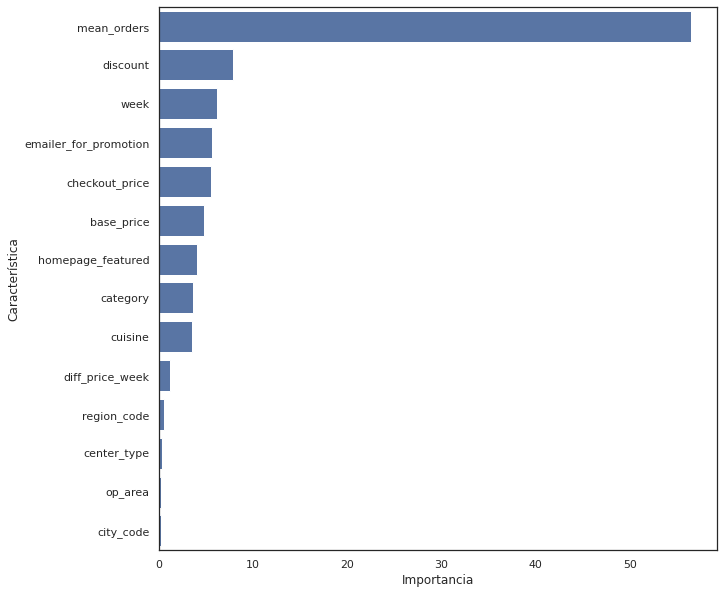

In [113]:
importances = pd.DataFrame({ 'importance': catboost_model_2.feature_importances_ })
importances['feature'] = x.columns
importances_sorted = importances.sort_values(by='importance', ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
fig =sns.barplot(x='importance',
                 y='feature', 
                 data=importances_sorted, 
                 label="Importancia de Características", 
                 color="b")

plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show(fig)

In [0]:
# Predicción
y_pred = catboost_model_2.predict(X_test)
predictions = pd.DataFrame({'id': ids, 
                           'num_orders': np.expm1(y_pred)})
predictions.to_csv('catboost_submission_model_2.csv', index=False)

#### Prueba 3: CatBoostRegressor con profuncidad 8 con feature engineering

In [115]:
x = X_train_categorical
y = Y_train
train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], []

categorical_columns_indexes = np.where(X_test_categorical.dtypes == 'object')[0]
#1000
catboost_model_3 = CatBoostRegressor(iterations=1600,
                                   learning_rate=0.01,
                                   max_depth=8,
                                   l2_leaf_reg=8, 
                                   loss_function='RMSE',
                                   use_best_model=True)

kfolds = KFold(n_splits=4, shuffle=True)

for train_idx, val_idx in kfolds.split(x):
  x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
  x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
  catboost_model_3.fit(x_train, y_train, cat_features=categorical_columns_indexes, eval_set=(x_val, y_val), verbose=200)
  train_scores.append(catboost_model_3.score(x_train, y_train))
  val_scores.append(catboost_model_3.score(x_val, y_val))
  train_rmsle.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(catboost_model_3.predict(x_train)))))
  val_rmsle.append(100 * np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(catboost_model_3.predict(x_val)))))

print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')

0:	learn: 1.1934830	test: 1.1952972	best: 1.1952972 (0)	total: 412ms	remaining: 10m 58s
200:	learn: 0.5493865	test: 0.5487459	best: 0.5487459 (200)	total: 1m 15s	remaining: 8m 43s
400:	learn: 0.5115744	test: 0.5104426	best: 0.5104426 (400)	total: 2m 23s	remaining: 7m 10s
600:	learn: 0.5001273	test: 0.4991635	best: 0.4991635 (600)	total: 3m 32s	remaining: 5m 53s
800:	learn: 0.4927131	test: 0.4919141	best: 0.4919141 (800)	total: 4m 41s	remaining: 4m 40s
1000:	learn: 0.4872643	test: 0.4866614	best: 0.4866614 (1000)	total: 5m 57s	remaining: 3m 33s
1200:	learn: 0.4832303	test: 0.4828302	best: 0.4828302 (1200)	total: 7m 5s	remaining: 2m 21s
1400:	learn: 0.4799014	test: 0.4796974	best: 0.4796974 (1400)	total: 8m 14s	remaining: 1m 10s
1599:	learn: 0.4768506	test: 0.4768706	best: 0.4768706 (1599)	total: 9m 23s	remaining: 0us

bestTest = 0.4768706015
bestIteration = 1599

0:	learn: 1.1947418	test: 1.1914557	best: 1.1914557 (0)	total: 398ms	remaining: 10m 35s
200:	learn: 0.5490224	test: 0.5485154

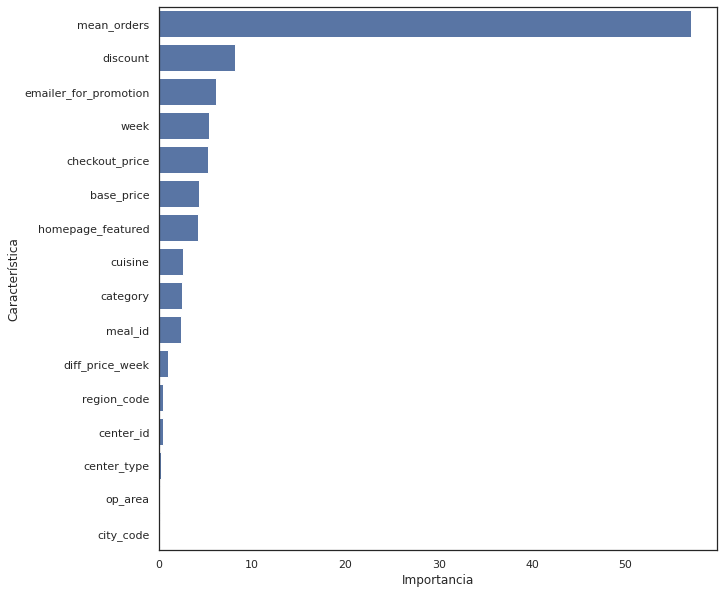

In [116]:
importances = pd.DataFrame({ 'importance': catboost_model_3.feature_importances_ })
importances['feature'] = x.columns
importances_sorted = importances.sort_values(by='importance', ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
fig =sns.barplot(x='importance',
                 y='feature', 
                 data=importances_sorted, 
                 label="Importancia de Características", 
                 color="b")

plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show(fig)

In [0]:
y_pred = catboost_model_3.predict(X_test_categorical)
predictions = pd.DataFrame({'id': ids, 
                           'num_orders': np.expm1(y_pred)})
predictions.to_csv('catboost_submission_model_3.csv', index=False)

## Referencias



1.   Notebook 1
[Food Demand Forecasting](https://github.com/SaiPrasath-S/DemandPrediction)
2.   Notebook 2 [Food Demand Forecasting](https://github.com/yashkim77/AV_Food_Demand_Challenge)
3. Video de Series Temporales [Time Series Analysis](https://www.youtube.com/watch?v=0lsmdNLNorY&list=PLeo1K3hjS3uvMADnFjV1yg6E5nVU4kOob&index=7)
4. Información CatBoost [CatBoost](https://catboost.ai/)
5. Learning Curve [Curva de Aprendizaje](https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/)
